<a href="https://colab.research.google.com/github/johanhoffman/DD2363_VT24/blob/chmntz_Lab1/Lab1/chmntz_Lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 1: Matrix factorization**
Carl **Chemnitz**

# **Abstract**
In this lab, 4 techniques and methods of solving systems of linear equations were implemented in Python along with tests to verify their accuracy.

The methods implemented were *sparse matrix multiplication*, *modfied Gram-Schmidt QR factorization*, *direct solver using backward substitution* and *least square*.

All methods performed according to expectation.

# **Set up environment**
To have access to the neccessary modules you have to run this cell.

In [140]:
from google.colab import files

import numpy as np
import scipy.sparse
import random as rd
import matplotlib.pyplot as plt

# **Introduction**
This lab puts focus on understanding and implementing various techniques and methods for solving systems of linear equations in the form of $Ax=b$. Specifically, direct solution methods, based on factorization of $A$ into product of matrices that are more optimized to handle (invert).

$Ax=b$ is simply solved by inverting $A$, yielding $x=A^{-1}b$. However, not all matrices are easy to invert, which is why direct methods factorizes $A$ into product matrices that are more easily invertable, such as orthogonal, triangular and diagonal matrices.

Gram-Schmidt QR factorization is one technique of factorizing a square matrix $A$ into an orthogonal matrix product $Q$ and an upper triangular matrix product $R$. These product matrices are more easily invertable. In this lab, a modified version of Gram-Schmidt was implemented to avoid accumulate round-off errors.

Some matrices are considered *sparse*, consisting of mostly $0$s. To avoid wasting computational power when operating such matrices, sparse matrix algorithm can be used. In this lab, a data structure named  *compressed row storage* is used as it stores the nonzero components in a much more compressed and efficient mannar than regular matrices.

There are some systems of linear equations that have inconsistent solution, i.e. no solutions. Examples could be recorded data. A fitted solution could be constructed by minimizing the errors. This technique is called least-squares.

## **Mandatory assignment**


1. Function: **sparse matrix-vector product**

**Input**: vector $x$, sparse (real, quadratic) matrix $A$: CRS arrays val, col_idx, row_ptr.\
**Output**: matrix-vector product $b=Ax$.\
**Test**: verify accuracy against dense matrix-vector product.



2. Function: QR factorization

**Input**: (real, quadratic, invertible) matrix $A$.\
**Output**: orthogonal matrix $Q$, upper traingular matrix $R$, such that $A=QR$.\
**Test**: $R$ upper traingular, Forbenius norms $||Q^TQ-I||_F$, $||QR-A||_F$.



3. Function: direct solver $Ax=b$



**Input**: (real, quadratic) matrix $A$, vector $b$.\
**Output**: vector $x=A^{-1}b$.\
**Test**: residual $||Ax-b||$, and $||x-y||$ where $y$ is a manufactured solution $b=Ay$.

## **Extra assignment**
4. Function: **least squares problem $Ax=b$**
**Input**: rectangular matrix $A$, vector $b$.\
**Output**: vector $x$.\
**Test**: residual $||Ax-b||$.

# **Method**
The implementation of each assignment.

## Sparse matrix-vector product
A sparse matrix is a matrix were most of its elements are zero. To optimize memory and efficiency of matrix-vector multiplication, *compressed row storage* data structures can be used. It consists of three arrays.
* `val`, the non-zero values.
* `col_idx`, their respective column indices.
* `row_ptr`, pointers to the start of each row.

`sparse_matrix_vector_product` was implemented based on algorithm **5.9** from Chapter 5 of Methods in Computational Science, and adjusted to 0-indexing.

In [141]:
def sparse_matrix_vector_product (val, col_idx, row_ptr, x) -> np.array:
    b = np.zeros(len(row_ptr)-1)
    for i in range(len(row_ptr)-1):
        for j in range(row_ptr[i], row_ptr[i+1]):
            b[i] += val[j] * x[col_idx[j]]
    return b


The standard (dense) matrix-vector multiplication algorithm was implemented based on algorithm **3.2** from Chapter 3 of Methods in Computational Science.

In [142]:
def matrix_vector_product (A, x) -> np.array:
    n = len(x)
    b = np.zeros(n)

    for i in range(len(A[:,0])):
        for j in range(0, n):
            b[i] += A[i,j] * x[j]
    return b

Random sparse matrices and vectors were constructed and multiplied using `sparse_matrix_vector_product` and `matrix_vector_product`, and then compared.

In [143]:
for i in range(5):
    A = scipy.sparse.random(i+5, i+5, density=0.3, format='csr')
    x = np.random.rand(i+5)

    sparse_b = sparse_matrix_vector_product(A.data, A.indices, A.indptr, x)
    dense_b = matrix_vector_product(A.todense(), x)
    print(f"Test {i},   Verification {'success' if (dense_b == sparse_b).all() else 'failure'}")


Test 0,   Verification success
Test 1,   Verification success
Test 2,   Verification success
Test 3,   Verification success
Test 4,   Verification success


In [144]:
%%timeit
sparse_matrix_vector_product(A.data, A.indices, A.indptr, x)

20.3 µs ± 1.15 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [145]:
%%timeit
matrix_vector_product(A.todense(), x)

107 µs ± 28.3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## QR factorization
A decomposition of a square matrix $A$ into an orthogonal matrix $Q$ and an upper triangular matrix $R$.
$$A=QR$$

`modified_gram_schmidt_iteration` was implemented according to algorithm **5.3** from *Methods of Computational Science*.

In [146]:
def modified_gram_schmidt_iteration(A) -> np.array:
    n = A.shape[0]
    Q = np.zeros(A.shape)
    R = np.zeros(A.shape)

    for j in range(0,n):
        v_j = A[:,j]
        for i in range(0,j):
            R[i,j] = Q[:,i] @ v_j
            v_j = v_j - (R[i,j] * Q[:,i])
        R[j,j] = np.linalg.norm(v_j)
        Q[:,j] = v_j / R[j,j]
    return Q, R

$R$ is checked whether it is a upper triangular matrix or not by using numpy's `triu` and `allclose` functions which creates an upper triangular matrix and compares it to $R$.

As discussed in the problem assignment, $Q^TQ=I$, thus $||Q^TQ-I||_F$ should be 0. We also know that $A=QR$, which means $||QR-A||_F$ also should be 0 as $Q$ and $R$ are factored from $A$.

In [147]:
A = np.random.random((4, 4))
Q, R = modified_gram_schmidt_iteration(A)
print(f"R upper triangular test: {np.allclose(R, np.triu(R))}")
print(f"||Q^T Q - I||_F=0: {np.allclose(np.identity(Q.shape[0]), Q.T @ Q)}")
print(f"||Q R - A||_F=0: {np.allclose(Q @ R, A)}")

R upper triangular test: True
||Q^T Q - I||_F=0: True
||Q R - A||_F=0: True


## Direct solver $Ax=b$
For a nonsingular, square matrix $A$, in a system of linear equations, $Ax=b$, the solution $x$ can be expressed as $x=A^{-1}b$.

A *direct method* is the technique of factorizing $A$ into matrix products that easy to invert, followed by the inversion of the factors. Orthogonal, diagonal and triangular matrices are easy to invert.

`direct_solver` is a combination of algorithm **5.2** from *Methods in Scientific Computation* and the previously implemented `modified_gram_schmidt_iteration` to find the upper triangle $U$ using $A=QR=QU$.
Backward substitution (algorithm **5.2**) is used invert the upper triangle matrix.
The equation is rewritten as:

$$Ax=b\Rightarrow QUx=B\Rightarrow x=R^{-1}Q^{-1}b$$
Since $Q$ is an orthogonal matrix, we know that $Q^{-1}=Q^T$.
$$Ax=b\Rightarrow R^{-1}Q^Tb$$

In [148]:
def direct_solver(A, b) -> np.array:
    n = A.shape[0]
    x = np.zeros(n)
    Q, U = modified_gram_schmidt_iteration(A)
    b = Q.T @ b

    # Backward substitution(U, b)
    x[n-1] = b[n-1] / U[n-1,n-1]
    for i in range(n-1, 0, -1):
        for j in range(i, n):
            x[i-1] += U[i-1,j] * x[j]
        x[i-1] = (b[i-1] - x[i-1]) / U[i-1,i-1]
    return x


In [149]:
A = np.random.random((6, 6))
b = np.random.rand(6)

x = direct_solver(A,b)
residual = np.linalg.norm(A@x)
print(f"||Ax-b||=0: {np.allclose(A@x, b)}")

y = np.random.rand(6)
x = direct_solver(A, A@y)
print(f"||x-y||=0: {np.allclose(x, y)}")

||Ax-b||=0: True
||x-y||=0: True


## Least squares problem
A least-squares solution is a approximate solution to an inconsistent equation $Ax=b$. By inconsistent equation, it means that there is no solution to $Ax=b$. It approximates the solution by minimizing the difference of $b-Ax$ as much as possible.

An orthogonal projector $P$ can be used to project $b$ onto range$(A)$ to find an approximate solution to $Ax=b$. This gives that $Pb\in\text{range}(A)\Rightarrow Pb=A \hat{x} $ and projection error $b-Pb=b-A\hat{x}\in\text{range}(A)^\perp$.

Since $\text{range}(A)^\perp=\text{null}(A^T)$ we get
$$A^T(b-A\hat{x})=0⇔A^TA\hat{x}=A^Tb$$

More information can be found in 2.7 in *Methods for Scientific Computation*.

If we use $A^TA\hat{x}=A^Tb$ and our previous implementation of Gram-Schmidt, we can solve $\hat{x}$. However, before we use Gram-Schmidt we must first modify the matrix and vector.
$$\begin{cases}
A_\text{new}=A_\text{input}^TA_\text{input} \\
b_\text{new}=A^T_\text{input}b
\end{cases}$$
**Note:** Any technique can be used to solve the equation, but the matrix and vector still have to be modified before the solving procedure.

In [150]:
def least_squares_problem(A, b) -> np.array:
    matrix = A.T @ A
    vector = A.T @ b
    return direct_solver(matrix, vector)

A random dataset with a trend was created to test the residual $||Ax-b||$. It was then also compared to Numpy's own function `np.linalg.lsqst`. This was done to determine if the implemented function was implemented correctly or not as the residual can be large depending on the dataset.

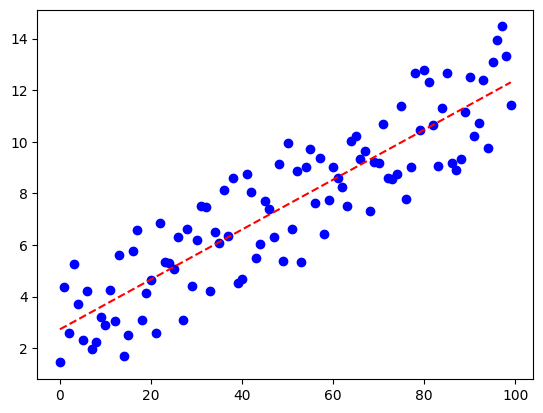

||A_x-b|| : 14.064606299746691
Difference compared to np.linalg.lsqst: 0.0


In [151]:
n = 100
x, y = np.zeros(n), np.zeros(n)
for i in range(n):
    y[i] = rd.uniform(0 + (i / 10), 5 + (i / 10))
    x[i] = i

A = np.array([np.ones(len(x)), x])
b = y
plt.plot(x, y, 'bo')

sol = least_squares_problem(A.T, b)
y_fit = x * sol[1] + sol[0]
plt.plot(x, y_fit, 'r--')
plt.show()

sol_np = np.linalg.lstsq(A.T, b, rcond=None)
print(f"||A_x-b|| : {np.linalg.norm(A.T@sol-b)}")
print(f"Difference compared to np.linalg.lsqst: {np.linalg.norm(A.T@sol-b)-np.linalg.norm(A.T@sol_np[0]-b)}")


# **Discussion**
All methods and implementations performed as expected and passed all tests. The only outstadning results were from the `linear_squares_problem` implementation as the residual was rather high. It is not to say it is wrong as the unfitted data was randomly generated. As it does differ from the inbuilt function, it perfomed as expected.